In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms,models
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from sklearn.model_selection import train_test_split
from timm.models.swin_transformer import SwinTransformer
from PIL import Image
import time
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import copy
from imblearn.over_sampling import SMOTE
from collections import Counter

In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
class MilkAdulterationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform
        
        for fat in os.listdir(root_dir):
            fat_path = os.path.join(root_dir, fat)
            if not os.path.isdir(fat_path):
                continue

            for percent in os.listdir(fat_path):
                percent_path = os.path.join(fat_path, percent)

                if percent == '0':
                    # Non-adulterated (class 0)
                    for img_name in os.listdir(percent_path):
                        self.data.append({
                            "img_path": os.path.join(percent_path, img_name),
                            "label": 0  # Hardcoded 0 for non-adulterated
                        })
                else:
                    # Adulterated (class 1)
                    for adulterant in os.listdir(percent_path):
                        adulterant_path = os.path.join(percent_path, adulterant)
                        if os.path.isdir(adulterant_path):
                            for img_name in os.listdir(adulterant_path):
                                self.data.append({
                                    "img_path": os.path.join(adulterant_path, img_name),
                                    "label": 1  # Hardcoded 1 for adulterated
                                })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image = Image.open(sample["img_path"]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, sample["label"]

In [6]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
data_dir = '/home/nitin/salmaan/RGB'
dataset = MilkAdulterationDataset(data_dir, transform=transform)

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


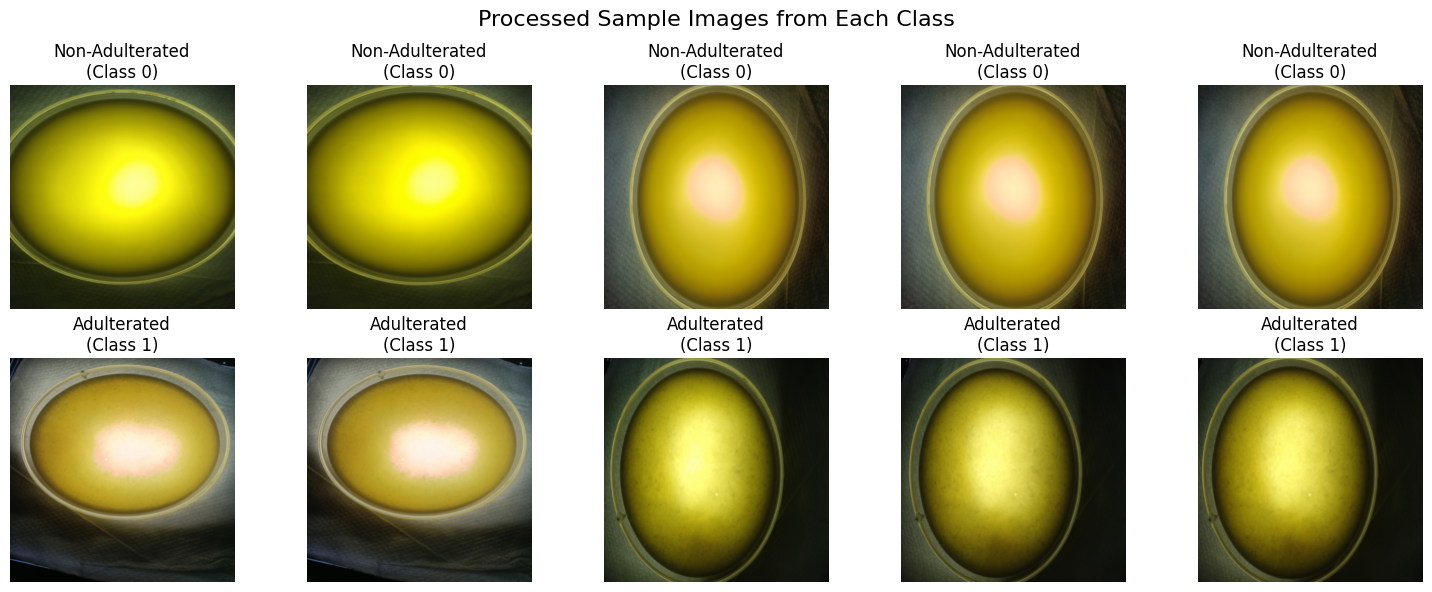

In [7]:
def plot_sample_images(dataset, samples_per_class=5):
    # Collect indices for each class
    class_indices = {0: [], 1: []}
    
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)
        if all(len(indices) >= samples_per_class for indices in class_indices.values()):
            break
    
    # Create figure
    fig, axes = plt.subplots(2, samples_per_class, figsize=(15, 6))
    fig.suptitle('Processed Sample Images from Each Class', fontsize=16)
    
    # Plot non-adulterated (class 0)
    for i, idx in enumerate(class_indices[0]):
        image, label = dataset[idx]
        ax = axes[0, i]
        ax.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        ax.set_title(f'Non-Adulterated\n(Class {label})')
        ax.axis('off')
    
    # Plot adulterated (class 1)
    for i, idx in enumerate(class_indices[1]):
        image, label = dataset[idx]
        ax = axes[1, i]
        ax.imshow(image.permute(1, 2, 0).numpy() * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
        ax.set_title(f'Adulterated\n(Class {label})')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


plot_sample_images(dataset,5)

Class distribution:
Non-adulterated (Class 0): 81 samples
Adulterated (Class 1): 997 samples
Total: 1078 samples


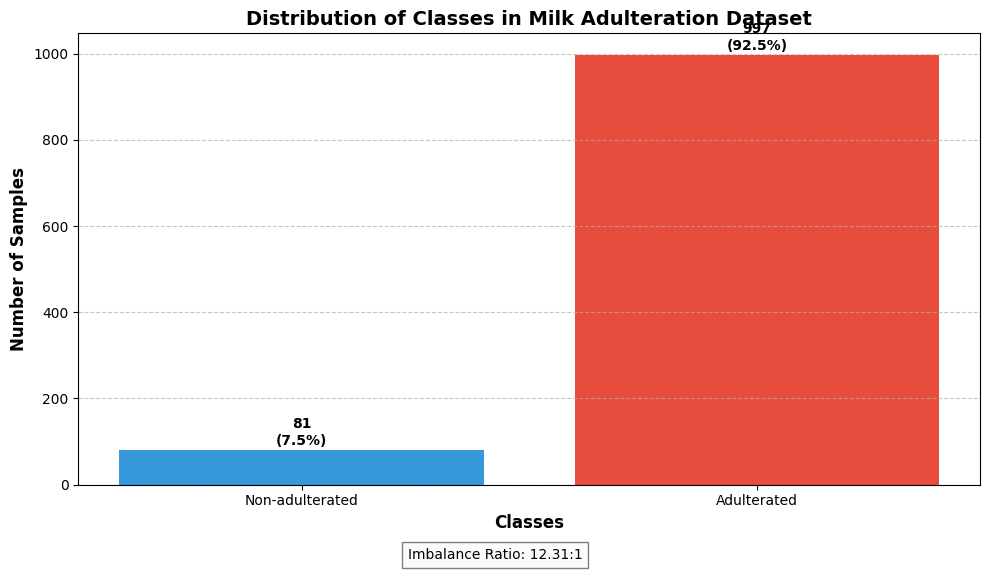

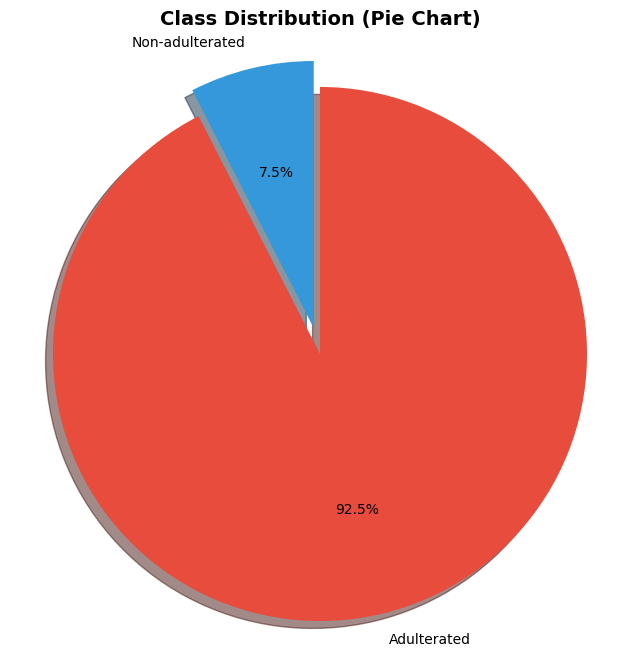

In [11]:
from collections import Counter

dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

# Count the number of samples for each class
class_counts = {0: 0, 1: 0}  # Initialize counters (0: non-adulterated, 1: adulterated)

for _, labels in dataloader:
    # Count occurrences of each label in the batch
    batch_counts = Counter(labels.numpy())
    for label, count in batch_counts.items():
        class_counts[label.item()] += count

# Print the counts
print("Class distribution:")
print(f"Non-adulterated (Class 0): {class_counts[0]} samples")
print(f"Adulterated (Class 1): {class_counts[1]} samples")
print(f"Total: {class_counts[0] + class_counts[1]} samples")

# Calculate class percentages
total_samples = sum(class_counts.values())
class_percentages = {k: (v / total_samples) * 100 for k, v in class_counts.items()}

# Create a bar plot
plt.figure(figsize=(10, 6))
classes = ['Non-adulterated', 'Adulterated']
counts = [class_counts[0], class_counts[1]]
colors = ['#3498db', '#e74c3c']

# Create the bar plot
bars = plt.bar(classes, counts, color=colors)

# Add count and percentage labels on top of each bar
for bar, count, percentage in zip(bars, counts, class_percentages.values()):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Add labels and title
plt.xlabel('Classes', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Distribution of Classes in Milk Adulteration Dataset', fontsize=14, fontweight='bold')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Calculate and display the imbalance ratio
imbalance_ratio = max(counts) / min(counts) if min(counts) > 0 else float('inf')
plt.figtext(0.5, 0.01, f'Imbalance Ratio: {imbalance_ratio:.2f}:1', 
            ha='center', fontsize=10, bbox=dict(facecolor='#f9f9f9', alpha=0.5))

# Improve visual appearance
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the plot (optional)
plt.savefig('milk_adulteration_class_distribution.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

# Additional visualization - Pie chart for class distribution
plt.figure(figsize=(8, 8))
plt.pie([class_counts[0], class_counts[1]], 
        labels=['Non-adulterated', 'Adulterated'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        explode=(0.05, 0.05),
        shadow=True)
plt.title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Save the pie chart (optional)
plt.savefig('milk_adulteration_class_distribution_pie.png', dpi=300, bbox_inches='tight')

# Show the pie chart
plt.show()

In [9]:


all_labels = [dataset[i][1] for i in range(len(dataset))]
all_indices = list(range(len(dataset)))

In [11]:
train_indices, temp_indices = train_test_split(
    all_indices,
    test_size=0.3,
    stratify=[all_labels[i] for i in all_indices],
    random_state=42
)

val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.67,  # 2/3 of the temp set (20% of total)
    stratify=[all_labels[i] for i in temp_indices],
    random_state=42
)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)



# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 754
Validation size: 106
Test size: 218


In [ ]:
def check_class_distribution(dataset_subset, name):
    labels = [dataset[idx][1] for idx in dataset_subset.indices]
    class_0_count = labels.count(0)
    class_1_count = labels.count(1)
    print(f"\n{name} set distribution:")
    print(f"  Non-adulterated (Class 0): {class_0_count} samples ({class_0_count/len(labels)*100:.1f}%)")
    print(f"  Adulterated (Class 1): {class_1_count} samples ({class_1_count/len(labels)*100:.1f}%)")

# Check distribution in each split
check_class_distribution(train_dataset, "Training")
check_class_distribution(val_dataset, "Validation")
check_class_distribution(test_dataset, "Test")

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Training set distribution:
  Non-adulterated (Class 0): 57 samples (7.6%)
  Adulterated (Class 1): 697 samples (92.4%)

Validation set distribution:
  Non-adulterated (Class 0): 8 samples (7.5%)
  Adulterated (Class 1): 98 samples (92.5%)

Test set distribution:
  Non-adulterated (Class 0): 16 samples (7.3%)
  Adulterated (Class 1): 202 samples (92.7%)


In [12]:
# Create data loaders with appropriate batch size
batch_size = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

# For Swin Transformer, we need to know the number of classes
num_classes = 2  # Since you have binary classification (0: non-adulterated, 1: adulterated)
print(f"Number of classes: {num_classes}")

Number of classes: 2


In [13]:
print("Extracting features for SMOTE analysis...")

def extract_features(dataset, max_samples=10000):
    # Create a data loader
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)
    
    features = []
    labels = []
    sample_count = 0
    
    for inputs, targets in loader:
        # Convert images to feature vectors
        # For simplicity, we'll resize images to a fixed size and flatten them
        # In a real scenario, you might want to use a pre-trained model to extract features
        batch_features = inputs.view(inputs.size(0), -1).numpy()  # Flatten the images
        batch_labels = targets.numpy()
        
        features.append(batch_features)
        labels.append(batch_labels)
        
        sample_count += inputs.size(0)
        if sample_count >= max_samples:
            break
            
    # Concatenate all batches
    features = np.vstack(features)
    labels = np.concatenate(labels)
    
    return features, labels

# Extract features from training data
train_features, train_labels = extract_features(train_dataset)

# Print original class distribution
print("Original class distribution:")
counter = Counter(train_labels)
for class_label, count in counter.items():
    print(f"Class {class_label}: {count} samples")

# Apply SMOTE to balance the classes
print("Applying SMOTE...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(train_features, train_labels)

# Print balanced class distribution
print("Balanced class distribution after SMOTE:")
counter = Counter(y_resampled)
for class_label, count in counter.items():
    print(f"Class {class_label}: {count} samples")

# Calculate optimal class weights based on original distribution
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (len(class_counts) * class_counts)
print(f"Calculated class weights: {class_weights}")

Extracting features for SMOTE analysis...


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Original class distribution:
Class 1: 697 samples
Class 0: 57 samples
Applying SMOTE...


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detec

Balanced class distribution after SMOTE:
Class 1: 697 samples
Class 0: 697 samples
Calculated class weights: [6.61403509 0.54088953]


In [14]:
class ResampledDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = features
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Reshape feature vector back to image format (assuming 3 channels, 224x224)
        feature = self.features[idx].reshape(3, 224, 224)
        feature_tensor = torch.FloatTensor(feature)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        if self.transform:
            feature_tensor = self.transform(feature_tensor)
            
        return feature_tensor, label

# Create resampled dataset and dataloader
resampled_train_dataset = ResampledDataset(X_resampled, y_resampled)
resampled_train_loader = DataLoader(
    resampled_train_dataset, 
    batch_size=32, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [15]:
model = SwinTransformer(
    img_size=224,
    patch_size=4,
    in_chans=3,
    num_classes=2,
    embed_dim=96,
    depths=[2, 2, 6, 2],
    num_heads=[3, 6, 12, 24],
    window_size=7,
)

In [16]:
device_ids = [0,1,2,3,4,5,6]

In [17]:
print(f"CUDA devices available: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA devices available: 7
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB
Device 2: NVIDIA A100-SXM4-40GB
Device 3: NVIDIA A100-SXM4-40GB
Device 4: NVIDIA A100-SXM4-40GB
Device 5: NVIDIA A100-SXM4-40GB
Device 6: NVIDIA A100-SXM4-40GB


In [18]:
device = torch.device(f"cuda:{device_ids[0]}" if torch.cuda.is_available() else "cpu")

# Load pre-trained weights
try:
    if hasattr(model, 'default_cfg') and 'url' in model.default_cfg:
        print("Loading pre-trained weights...")
        state_dict = torch.hub.load_state_dict_from_url(model.default_cfg['url'], progress=True)
        model.load_state_dict(state_dict, strict=False)
    else:
        print("No pre-trained weights available. Training from scratch.")
except Exception as e:
    print(f"Warning: Failed to load pre-trained weights: {e}")
    print("Training from scratch.")

# Parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1 and len(device_ids) > 1:
    print(f"Using {len(device_ids)} GPUs: {device_ids}")
    model = nn.DataParallel(model, device_ids=device_ids)

model.to(device)

No pre-trained weights available. Training from scratch.
Using 7 GPUs: [0, 1, 2, 3, 4, 5, 6]


DataParallel(
  (module): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=Tru

In [19]:
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [20]:
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [21]:
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=30):
    start_time = time.time()
    
    # Initialize history dictionaries
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1': []  # Track F1 score as well
    }
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_val_f1 = 0.0  # Use F1 score for model selection
    early_stopping_counter = 0
    early_stopping_patience = 5
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader
            
            running_loss = 0.0
            all_preds = []
            all_labels = []
            
            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass (track history only in train)
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass (only during training)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            # Calculate metrics for the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = accuracy_score(all_labels, all_preds)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted')
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')
            
            # Print confusion matrix for validation
            if phase == 'val':
                cm = confusion_matrix(all_labels, all_preds)
                print(f"Validation Confusion Matrix:\n{cm}")
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:  # phase == 'val'
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                history['val_f1'].append(epoch_f1)
                
                # Update learning rate based on validation loss
                scheduler.step(epoch_loss)
                
                # Check for improvement using F1 score
                if epoch_f1 > best_val_f1:
                    print(f"Validation F1 improved from {best_val_f1:.4f} to {epoch_f1:.4f}")
                    best_val_f1 = epoch_f1
                    best_model_weights = copy.deepcopy(model.state_dict())
                    early_stopping_counter = 0
                    
                    # Save the current best model
                    model_save_path = 'swin_2class_best.pth'
                    if isinstance(model, nn.DataParallel):
                        torch.save(model.module.state_dict(), model_save_path)
                    else:
                        torch.save(model.state_dict(), model_save_path)
                    print(f"Model saved to {model_save_path}")
                else:
                    early_stopping_counter += 1
                    print(f"EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}")
                    
                    if early_stopping_counter >= early_stopping_patience:
                        print("Early stopping triggered")
                        # Load best model weights
                        model.load_state_dict(best_model_weights)
                        return model, history
        
        print()
    
    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, history

In [22]:
print("Starting training with SMOTE-resampled data...")
model, history = train_model(model, criterion, optimizer, scheduler, 
                            resampled_train_loader, val_loader, num_epochs=30)

Starting training with SMOTE-resampled data...
Epoch 1/30
----------
train Loss: 0.3097 Acc: 0.5079 F1: 0.3612


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 1.0845 Acc: 0.1509 F1: 0.1509
Validation Confusion Matrix:
[[ 8  0]
 [90  8]]
Validation F1 improved from 0.0000 to 0.1509
Model saved to swin_2class_best.pth

Epoch 2/30
----------
train Loss: 0.2308 Acc: 0.6220 F1: 0.5600


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 1.7192 Acc: 0.0943 F1: 0.0478
Validation Confusion Matrix:
[[ 8  0]
 [96  2]]
EarlyStopping counter: 1 out of 5

Epoch 3/30
----------
train Loss: 0.2099 Acc: 0.6062 F1: 0.5357


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 0.5334 Acc: 0.7736 F1: 0.8236
Validation Confusion Matrix:
[[ 6  2]
 [22 76]]
Validation F1 improved from 0.1509 to 0.8236
Model saved to swin_2class_best.pth

Epoch 4/30
----------
train Loss: 0.1553 Acc: 0.7461 F1: 0.7294


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 0.6158 Acc: 0.6321 F1: 0.7168
Validation Confusion Matrix:
[[ 8  0]
 [39 59]]
EarlyStopping counter: 1 out of 5

Epoch 5/30
----------
train Loss: 0.1232 Acc: 0.8092 F1: 0.8022


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 0.6873 Acc: 0.7170 F1: 0.7837
Validation Confusion Matrix:
[[ 8  0]
 [30 68]]
EarlyStopping counter: 2 out of 5

Epoch 6/30
----------
train Loss: 0.1089 Acc: 0.8515 F1: 0.8484


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 2.1720 Acc: 0.1792 F1: 0.1983
Validation Confusion Matrix:
[[ 8  0]
 [87 11]]
EarlyStopping counter: 3 out of 5

Epoch 7/30
----------
train Loss: 0.1731 Acc: 0.6944 F1: 0.6629


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 0.8397 Acc: 0.5283 F1: 0.6262
Validation Confusion Matrix:
[[ 8  0]
 [50 48]]
EarlyStopping counter: 4 out of 5

Epoch 8/30
----------
train Loss: 0.1050 Acc: 0.8185 F1: 0.8123


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


val Loss: 0.6205 Acc: 0.6509 F1: 0.7322
Validation Confusion Matrix:
[[ 8  0]
 [37 61]]
EarlyStopping counter: 5 out of 5
Early stopping triggered


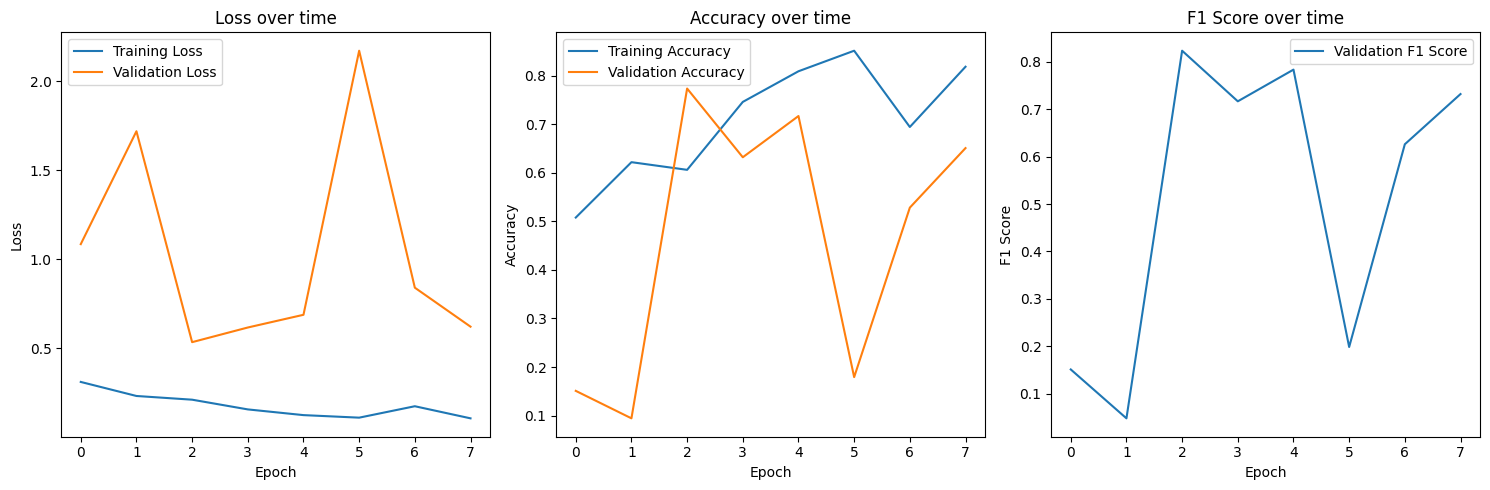

In [23]:
plt.figure(figsize=(15, 5))

# Plot training & validation loss
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over time')
plt.legend()

# Plot validation F1 score
plt.subplot(1, 3, 3)
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over time')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_smote.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
def load_model(model_path):
    model = SwinTransformer(
        img_size=224,
        patch_size=4,
        in_chans=3,
        num_classes=2,
        embed_dim=96,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        window_size=7,
    )
    
    # Load weights
    state_dict = torch.load(model_path, map_location=device)
    
    # Check if we need to remap keys
    if 'head.fc.weight' in state_dict and 'head.weight' not in state_dict:
        print("Remapping state dict keys...")
        new_state_dict = {}
        for k, v in state_dict.items():
            if k == 'head.fc.weight':
                new_state_dict['head.weight'] = v
            elif k == 'head.fc.bias':
                new_state_dict['head.bias'] = v
            else:
                new_state_dict[k] = v
        state_dict = new_state_dict
    
    # Try loading with strict=False first
    try:
        model.load_state_dict(state_dict, strict=False)
        print("Model loaded successfully with strict=False")
    except Exception as e:
        print(f"Warning: {e}")
        print("Attempting to load with more aggressive key remapping...")
        
        # Print some keys for debugging
        print("Keys in saved model:", list(state_dict.keys())[:5])
        print("Keys in new model:", list(model.state_dict().keys())[:5])
        
        # More aggressive remapping
        new_state_dict = {}
        model_keys = model.state_dict().keys()
        
        for i, (k_new, k_old) in enumerate(zip(model_keys, state_dict.keys())):
            new_state_dict[k_new] = state_dict[k_old]
            if i < 5:
                print(f"Mapping {k_old} to {k_new}")
        
        model.load_state_dict(new_state_dict, strict=False)
        print("Model loaded with aggressive key remapping")
    
    return model

In [25]:
def evaluate_model(model, dataloader, threshold=0.5, criterion=None):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            
            # Use custom threshold for prediction
            preds = (probs[:, 1] > threshold).long()
            
            if criterion:
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=['Non-adulterated', 'Adulterated'])
    
    if criterion:
        loss = running_loss / len(dataloader.dataset)
        return accuracy, precision, recall, f1, conf_matrix, class_report, loss, all_probs, all_labels
    
    return accuracy, precision, recall, f1, conf_matrix, class_report, all_probs, all_labels


In [26]:
print("\nLoading best model for testing...")
best_model = load_model('swin_2class_best.pth')
best_model.to(device)

print("Finding optimal threshold...")
test_metrics = evaluate_model(best_model, test_loader)
test_probs = test_metrics[-2]
test_labels = test_metrics[-1]

# Test various thresholds to find the best one
thresholds = np.arange(0.1, 0.9, 0.05)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    preds = (np.array(test_probs) > thresh).astype(int)
    f1 = f1_score(test_labels, preds, average='weighted')
    print(f"Threshold: {thresh:.2f}, F1: {f1:.4f}")
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Best threshold: {best_threshold:.2f} with F1: {best_f1:.4f}")

# Evaluate with the optimal threshold
print(f"Evaluating on test set with threshold = {best_threshold}...")
test_metrics = evaluate_model(best_model, test_loader, threshold=best_threshold, criterion=criterion)



Loading best model for testing...


/tmp/ipykernel_1085011/1090651436.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Remapping state dict keys...
Model loaded successfully with strict=False
Finding optimal threshold...


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Threshold: 0.10, F1: 0.8913
Threshold: 0.15, F1: 0.8913
Threshold: 0.20, F1: 0.8913
Threshold: 0.25, F1: 0.9082
Threshold: 0.30, F1: 0.7766
Threshold: 0.35, F1: 0.6184
Threshold: 0.40, F1: 0.4097
Threshold: 0.45, F1: 0.1855
Threshold: 0.50, F1: 0.0283
Threshold: 0.55, F1: 0.0100
Threshold: 0.60, F1: 0.0100
Threshold: 0.65, F1: 0.0100
Threshold: 0.70, F1: 0.0100
Threshold: 0.75, F1: 0.0100
Threshold: 0.80, F1: 0.0100
Threshold: 0.85, F1: 0.0100
Best threshold: 0.25 with F1: 0.9082
Evaluating on test set with threshold = 0.25000000000000006...


/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/nitin/miniforge3/envs/acps_salmaan/lib/python3.8/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (108576768 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Loss: 0.7449
Test Accuracy: 0.8991
Precision: 0.9207
Recall: 0.8991
F1 Score: 0.9082

Classification Report:
                 precision    recall  f1-score   support

Non-adulterated       0.38      0.56      0.45        16
    Adulterated       0.96      0.93      0.94       202

       accuracy                           0.90       218
      macro avg       0.67      0.74      0.70       218
   weighted avg       0.92      0.90      0.91       218


Confusion Matrix:
[[  9   7]
 [ 15 187]]


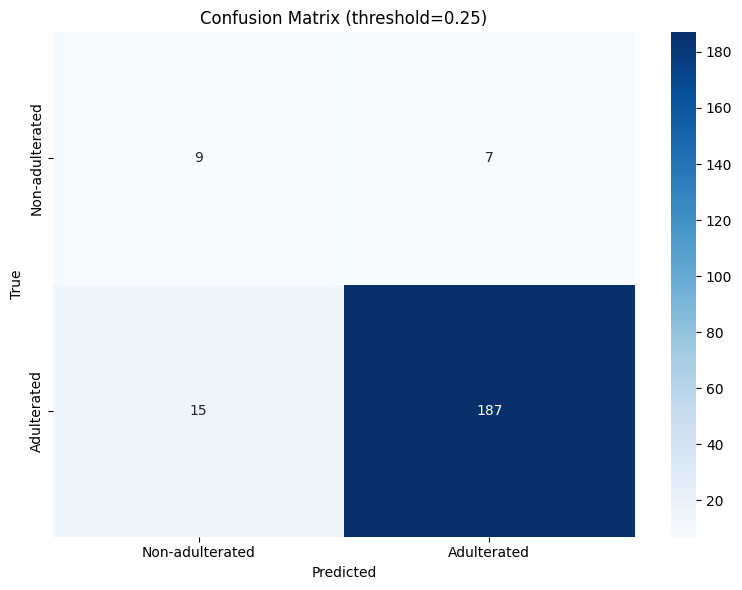

In [27]:
accuracy, precision, recall, f1, conf_matrix, class_report, test_loss, _, _ = test_metrics

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(class_report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-adulterated', 'Adulterated'],
            yticklabels=['Non-adulterated', 'Adulterated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix (threshold={best_threshold:.2f})')
plt.tight_layout()
plt.savefig('confusion_matrix_optimized.png', dpi=300, bbox_inches='tight')
plt.show()

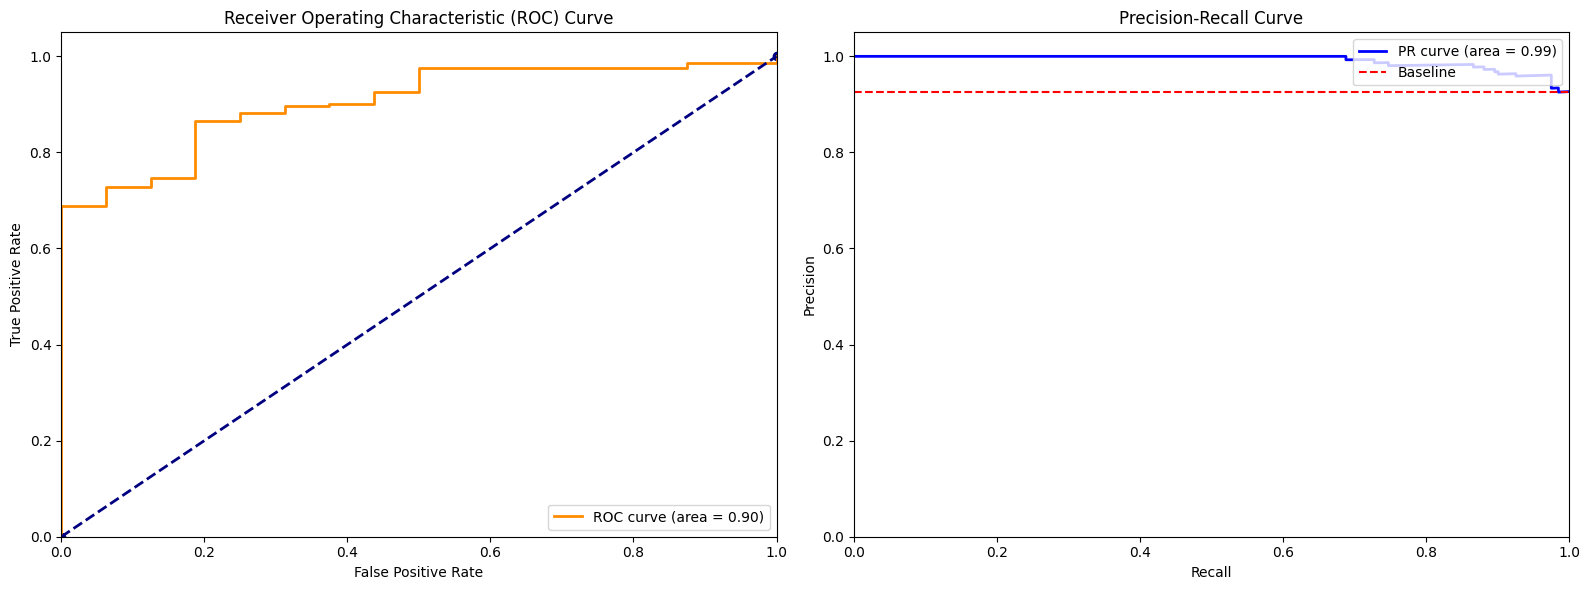

ROC AUC: 0.9035
PR AUC: 0.9918

Evaluation complete. Results saved to 'model_evaluation_report_optimized.txt'


In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

# Calculate precision-recall curve
precision_curve, recall_curve, _ = precision_recall_curve(test_labels, test_probs)
pr_auc = average_precision_score(test_labels, test_probs)

# Create a figure with two subplots
plt.figure(figsize=(16, 6))

# Plot ROC curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter([0, 1], [0, 1], color='navy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot precision-recall curve
plt.subplot(1, 2, 2)
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.axhline(y=sum(test_labels)/len(test_labels), color='red', linestyle='--', label='Baseline')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# Save a comprehensive summary report
with open('model_evaluation_report_optimized.txt', 'w') as f:
    f.write("Milk Adulteration Detection - Swin Transformer Model Evaluation (Optimized)\n")
    f.write("="*80 + "\n\n")
    f.write(f"Optimal Threshold: {best_threshold:.2f}\n")
    f.write(f"Test Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"ROC AUC: {roc_auc:.4f}\n")
    f.write(f"PR AUC: {pr_auc:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report + "\n\n")
    f.write("Confusion Matrix:\n")
    f.write(str(conf_matrix) + "\n\n")
    f.write("Class Weights Used:\n")
    f.write(str(class_weights) + "\n")
    
print("\nEvaluation complete. Results saved to 'model_evaluation_report_optimized.txt'")